In [3]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 1.x selected.
1.15.2


In [7]:
#@title Training 1: Load and Pre-Process Data
## Load Data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dataset_path = "/content/drive/My Drive/CMPT414_Project/Dataset/cifar-10-batches-py"

filename = dataset_path+"/data_batch_1"
dic1 = unpickle(filename) 

filename = dataset_path+"/data_batch_2"
dic2 = unpickle(filename) 

filename = dataset_path+"/data_batch_3"
dic3 = unpickle(filename) 

filename = dataset_path+"/data_batch_4"
dic4 = unpickle(filename) 

filename = dataset_path+"/data_batch_5"
dic5 = unpickle(filename) 

filename = dataset_path+"/test_batch"
dic6 = unpickle(filename) 

import numpy as np
import time

# Data Pre-processing
X = np.array(dic1[b'data'])[:,0:1024]
X = np.append(X, dic2[b'data'][:,0:1024],axis=0)
X = np.append(X, dic3[b'data'][:,0:1024],axis=0)
X = np.append(X, dic4[b'data'][:,0:1024],axis=0)
X = np.append(X, dic5[b'data'][:,0:1024],axis=0)
Y = np.array(dic1[b'labels'])
Y = np.append(Y, dic2[b'labels'],axis=0)
Y = np.append(Y, dic3[b'labels'],axis=0)
Y = np.append(Y, dic4[b'labels'],axis=0)
Y = np.append(Y, dic5[b'labels'],axis=0)
test_X = np.array(dic6[b'data'])[:,0:1024]
test_Y = np.array(dic6[b'labels'])

shapeX = np.reshape(X,(X.shape[0],32,32,1))
shape_test_X = np.reshape(test_X,(test_X.shape[0],32,32,1))

# forming Y array
a = np.zeros((Y.shape[0],10))
for i in  range(0,Y.shape[0]):
  a[i,Y[i]] = 1
Y = a

a = np.zeros((test_Y.shape[0],10))
for i in  range(0,test_Y.shape[0]):
  a[i,test_Y[i]] = 1
test_Y = a

print(X.shape)
print(Y.shape)
print(test_X.shape)
print(test_Y.shape)

(50000, 1024)
(50000, 10)
(10000, 1024)
(10000, 10)


In [0]:
#@title Training 2: Define data generator for Data Augmentation
%tensorflow_version 1.x
from tensorflow.python.keras import preprocessing
import numpy as np

## Data generator, used for Data Augmentation
dg = preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)


TensorFlow 1.x selected.


In [0]:
#@title Training 3: Define Model
%tensorflow_version 1.x
from tensorflow.python.keras import models , optimizers , losses ,activations
from tensorflow.python.keras.layers import *
from PIL import Image
import tensorflow as tf
import time
import os
import numpy as np

## Model
class Classifier (object) :

    def __init__( self , num_classes, dropout_rate, num_dense_tensor, learning_rate=0.001,datagen=None):
        self.__datagen = datagen
        self.__DIMEN = 32

        input_shape = ( self.__DIMEN ,self.__DIMEN, 1 )

        self.__NEURAL_SCHEMA = [

            Conv2D(32, kernel_size=(3, 3) , strides=1 , activation=activations.relu,input_shape=input_shape),
            Conv2D(32, kernel_size=(3, 3) , strides=1 , activation=activations.relu),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Conv2D(64, kernel_size=(3, 3) , strides=1 , activation=activations.relu),
            Conv2D(64, kernel_size=(3, 3) , strides=1 , activation=activations.relu),
            MaxPooling2D(pool_size=(2, 2) , strides=2),     

            Flatten(),          
            
            Dropout(dropout_rate),

            Dense( num_dense_tensor, activation=activations.relu) ,
            Dense( num_dense_tensor, activation=activations.relu) ,
            Dense( num_dense_tensor, activation=activations.relu) ,
            Dense( num_classes, activation=tf.nn.softmax)

        ]

        self.__model = tf.keras.Sequential( self.__NEURAL_SCHEMA )
        
        self.__model.compile(
            optimizer=optimizers.Adam(lr=learning_rate),
            loss=losses.categorical_crossentropy ,
            metrics=[ 'accuracy' ] ,
        )

    def fit_dg(self, x_train,y_train,hyperparameters):
        self.__model.fit_generator(self.__datagen.flow(x_train, y_train, 
                                                       batch_size = hyperparameters['batch_size']),
                                                       steps_per_epoch=len(x_train) / hyperparameters['batch_size'], 
                                                       epochs=hyperparameters['epochs'],
                                                       callbacks=hyperparameters['callbacks'],
                                                       validation_data=hyperparameters['val_data'])
        self.__model.summary()

    def fit(self, X, Y  , hyperparameters):
        self.__model.fit(X, Y,
                         batch_size=hyperparameters['batch_size'],
                         epochs=hyperparameters['epochs'],
                         callbacks=hyperparameters['callbacks'],
                         validation_data=hyperparameters['val_data']
                         )
        self.__model.summary()
    
    def summary():
        self.__model.summary()
  
    def evaluate(self , test_X , test_Y  ) :
        return self.__model.evaluate(test_X, test_Y)

    def predict(self, X  ):
        predictions = self.__model.predict( X  )
        return predictions

    def save_model(self , file_path ):
        self.__model.save(file_path )

    def print_model(self, file_path):
        tf.keras.utils.plot_model(self.__model,to_file=file_path)

    def load_model(self , file_path ):
        self.__model = models.load_model(file_path)

In [0]:
#@title Training 4: Setup Tensorboard and Train
# tensor board
fp = "/content/drive/My Drive/CMPT414_Project/Log/tmp"
tb = tf.keras.callbacks.TensorBoard(log_dir=fp, histogram_freq=0,  
          write_graph=True, write_images=True)

classifier = Classifier( num_classes=10,dropout_rate=0.5,num_dense_tensor=4096,
                        learning_rate=0.001,datagen=dg )

parameters = {
    'batch_size' : 250 ,
    'epochs' : 200 ,
    'callbacks' : [tb] ,
    #'callbacks' : None ,
    'val_data' : None
}

## start training
#classifier.fit(shapeX,Y,hyperparameters=parameters)
classifier.fit_dg(shapeX,Y,hyperparameters=parameters)

## Check training result on test data
loss , accuracy = classifier.evaluate( shape_test_X , test_Y )
print( "Loss of {}".format( loss ) , "Accuracy of {} %".format( accuracy * 100 ) )


Epoch 1/200
200/200 [==============================] - 19s 97ms/step - loss: 3.1259 - acc: 0.2385
Epoch 2/200
200/200 [==============================] - 18s 88ms/step - loss: 1.7184 - acc: 0.3801
Epoch 3/200
200/200 [==============================] - 18s 89ms/step - loss: 1.5540 - acc: 0.4485
Epoch 4/200
200/200 [==============================] - 18s 89ms/step - loss: 1.4128 - acc: 0.5016
Epoch 5/200
200/200 [==============================] - 18s 89ms/step - loss: 1.3235 - acc: 0.5368
Epoch 6/200
200/200 [==============================] - 18s 90ms/step - loss: 1.2466 - acc: 0.5646
Epoch 7/200
200/200 [==============================] - 18s 89ms/step - loss: 1.1761 - acc: 0.5887
Epoch 8/200
200/200 [==============================] - 18s 88ms/step - loss: 1.1316 - acc: 0.6061
Epoch 9/200
200/200 [==============================] - 18s 90ms/step - loss: 1.0973 - acc: 0.6176
Epoch 10/200
200/200 [==============================] - 18s 89ms/step - loss: 1.0631 - acc: 0.6280
Epoch 11/200
200/20

In [0]:
# save model
fp = "/content/drive/My Drive/CMPT414_Project/Model/tmp"
classifier.save_model(file_path=fp)

In [9]:
#@title Demo 1: Load Model and Initialize Label (need to load Training 1 and 3 before execute)
# load model
fp = "/content/drive/My Drive/CMPT414_Project/Model/81%_200ep_aug_new"
classifier = Classifier( num_classes=10,dropout_rate=0.5,num_dense_tensor=4096,
                        learning_rate=0.001)
classifier.load_model(file_path=fp)
truth = np.array(dic6[b'labels'])
label= ["airplane","automobile","bird","cat","deer","dog","frog","horse",
        "ship","truck"]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


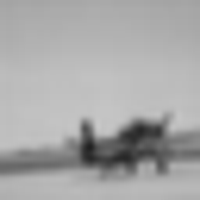

output softmax array:  [[9.9965930e-01 1.2317200e-06 2.3139891e-07 3.2534082e-08 2.3277030e-07
  1.2444256e-08 4.5759871e-09 9.0817360e-07 3.3127298e-04 6.8268778e-06]]
predict:  airplane
truth:  airplane


In [12]:
#@title Demo 2: Show Random Testing Images and Predict
import IPython.display
import PIL.Image
import random
i = random.randint(0,9999)
data = np.array(dic6[b'data'])[i,0:1024]
data = np.reshape(data,(32,32))
img =PIL.Image.fromarray(data)
IPython.display.display(img.resize((200,200)))
predict = classifier.predict(np.reshape(data,(1,32,32,1)))
print("output softmax array: ", predict)
print("predict: ", label[np.argmax(predict)])
print("truth: ", label[truth[i]])

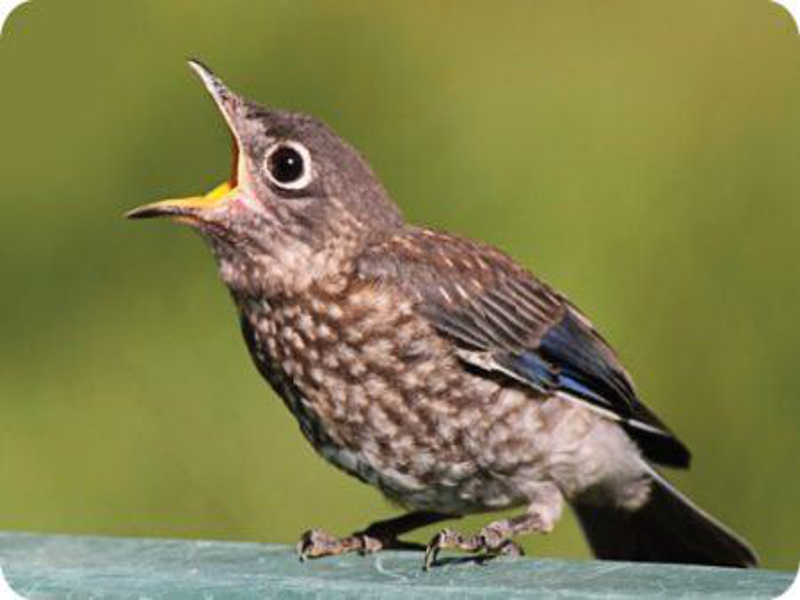

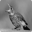

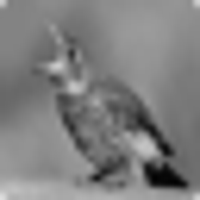

output softmax array:  [[9.9192112e-05 1.8453038e-05 9.9828714e-01 3.8586184e-04 1.6185001e-06
  2.5484651e-05 1.1612482e-03 1.3600359e-05 5.5150131e-06 1.9163297e-06]]
predict:  bird


In [24]:
#@title Demo 3: Show Random Images From Google Search and Predict)
# load model
import IPython.display
import PIL.Image
import numpy
import random
from os import listdir
from os.path import isfile, join
fp = "/content/drive/My Drive/CMPT414_Project/DemoImage"
onlyfiles = [f for f in listdir(fp) if isfile(join(fp, f))]
i = random.randint(0,len(onlyfiles)-1)
fp = fp+"/"+onlyfiles[i]

im = Image.open(fp)
img = im.resize((32,32))
data = numpy.array(img.getdata(),dtype='uint8').reshape(img.size[0], img.size[1], 3,)
data = data[:,:,1]

IPython.display.display(im.resize((800,600)))
small_img =PIL.Image.fromarray(data)
IPython.display.display(small_img)
IPython.display.display(small_img.resize((200,200)))
predict = classifier.predict(numpy.reshape(data,(1,32,32,1)))
print("output softmax array: ", predict)
print("predict: ", label[np.argmax(predict)])